# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [1]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

/Users/wangqin/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)

        self.value = None
        self.gradients = {}
        

    def forward(self):
        raise NotImplemented
    

    def backward(self):
        raise NotImplemented

In [3]:
class Input(Node):
    def __init__(self):
        Node.__init__(self)

    def forward(self, value=None):
        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1


In [4]:
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)

    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))

In [5]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)


In [6]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])

    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.


In [7]:
class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])

    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff

In [8]:
def forward_and_backward(outputnode, graph):
    for n in graph:
        n.forward()

    for n in  graph[::-1]:
        n.backward()


In [9]:
def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}

        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]

        L.append(n)
#         print(n.outputs)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

# feed_dict = {
#     X: X_,
#     y: y_,
#     W1: W1_,
#     b1: b1_,
#     W2: W2_,
#     b2: b2_
# }
# topological_sort(feed_dict)

In [10]:
def sgd_update(trainables, learning_rate=1e-2):
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [11]:
from sklearn.datasets import load_boston
data = load_boston()
losses = []

In [12]:
from sklearn.utils import shuffle, resample

X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}
# print(feed_dict)
epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
# print(graph)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 200.702
Epoch: 101, Loss: 6.822
Epoch: 201, Loss: 4.840
Epoch: 301, Loss: 4.556
Epoch: 401, Loss: 4.094
Epoch: 501, Loss: 4.060
Epoch: 601, Loss: 3.765
Epoch: 701, Loss: 5.129
Epoch: 801, Loss: 4.391
Epoch: 901, Loss: 3.705
Epoch: 1001, Loss: 3.497
Epoch: 1101, Loss: 3.677
Epoch: 1201, Loss: 3.989
Epoch: 1301, Loss: 3.790
Epoch: 1401, Loss: 3.223
Epoch: 1501, Loss: 3.189
Epoch: 1601, Loss: 3.871
Epoch: 1701, Loss: 3.151
Epoch: 1801, Loss: 2.782
Epoch: 1901, Loss: 3.336
Epoch: 2001, Loss: 2.836
Epoch: 2101, Loss: 3.037
Epoch: 2201, Loss: 3.052
Epoch: 2301, Loss: 3.183
Epoch: 2401, Loss: 3.121
Epoch: 2501, Loss: 2.851
Epoch: 2601, Loss: 3.008
Epoch: 2701, Loss: 2.448
Epoch: 2801, Loss: 2.954
Epoch: 2901, Loss: 2.783
Epoch: 3001, Loss: 2.799
Epoch: 3101, Loss: 2.695
Epoch: 3201, Loss: 2.567
Epoch: 3301, Loss: 3.115
Epoch: 3401, Loss: 2.515
Epoch: 3501, Loss: 2.648
Epoch: 3601, Loss: 3.185
Epoch: 3701, Loss: 2.511
Epoch: 3801, Loss: 2.796
Epoc

### 2. 回答一下理论题目

#### 1. What does a neuron compute?

Ans: A neuron firstly computes linear weighted values with inputs and weights (plus constant values), then a activation function will take the value to perform a non-linear transformation to get an output value.

####  2. Why we use non-linear activation funcitons in neural networks?

Ans: Without non-linear functions, there are only linear functions in neural networks, which would lead to a condition that we can in fact use a linear function to finish whole computation and the number of hidden layers has nothing to do with the final outputs.

#### 3. What is the 'Logistic Loss' ?

Ans: It's used to measure the difference between transformed values and actual values in the sigmoid function.

$$ Loss = -\sum{ylog\hat{y} + (1-y)log(1-\hat{y})} $$
    (Suppose: y is the actual value; y_hat is the transformed value.)

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommend using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

    Both sigmoid and tanh functions have advantages that they are continous and derivable in the real number region, while their disadvantages are that their decent rate can be very slow when the x is very large or small, that would lead to slow convergence. 

    Due to such disadvantages, the ReLU is used because it has a constant derivate, although it's not deriavted in the 0 and it's derivate is 0 when x is less than 0. And Leaky ReLU further amends shortcomings, and also have a constant derivate in the region from negative infinite to 0. Both of ReLU and Leaky ReLU make the convergence rate stable and not slow.

    Taken all of that, I recommend sigmoid or tanh when the input x is small, while it's Leaky ReLU when x is large. In fact, the Leaky ReLU is used more universally due to its better performance. 

#### 5. Why we don't use zero initialization for all parameters ?

Ans: If we use zero initialization for all parameters, then during the parameters update, we will get same parameters for the neurons in the same hidden layer, which means that the large numbers of neurons are meaningless.

#### 6. Can you implement the softmax function using python ? 

Ans: Yes, I can. When it comes to multiple classification, we use softmax function to compute the probability of a thing belonging to one type, then we consider the type with the largest probability is the true type. In the function, we first use the exponential function to transform probability, then we normalize these transformed probability by dividing the sum of transformed probability, then use the following formula to compute.

$$ S_j = \frac{e^{aj}}{\sum{e^{ak}}} $$
$$ L = -\sum\limits_{j=1}^{m}{y_jlogS_j} $$

### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [14]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/Users/wangqin/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [23]:
# Loading the data 
digits = datasets.load_digits()
digits.data[1]#.shape
# digits['DESCR']
# digits.column_names
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
         [ 0.,  0., 13., ..., 15.,  5.,  0.],
         [ 0.,  3., 15., ..., 11.,  8.,  0.],
         ...,
         [ 0.,  4., 11., ..., 12.,  7.,  0.],
         [ 0.,  2., 14., ..., 12.,  0.,  0.],
         [ 0.,  0.,  6., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
         [ 0.,  0.,  0., ...,  9.,  0.,  0.],
         [ 0.,  0.,  3., ...,  6.,  0.,  0.],
         ...,
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  0., ..., 10.,  0.,  0.]],
 
        [[ 0

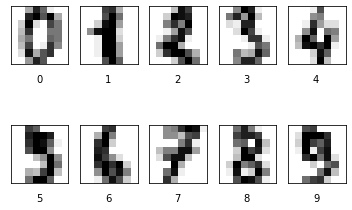

In [41]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap='gray_r')#plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [44]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)
# print(X_train.shape)
# X_test.shape
y_test

array([8, 3, 4, 0, 5, 3, 5, 4, 2, 3, 8, 4, 0, 5, 7, 4, 1, 7, 1, 7, 2, 3,
       0, 9, 8, 2, 5, 6, 4, 1, 6, 4, 5, 5, 4, 8, 1, 1, 6, 5, 9, 3, 4, 7,
       8, 7, 5, 0, 1, 3, 4, 4, 7, 8, 1, 2, 6, 0, 0, 5, 4, 7, 1, 6, 1, 2,
       1, 2, 5, 1, 3, 8, 8, 6, 8, 6, 8, 4, 4, 3, 0, 6, 4, 5, 8, 0, 6, 5,
       0, 7, 1, 2, 9, 1, 4, 8, 6, 9, 2, 0, 7, 4, 6, 5, 6, 4, 0, 2, 2, 6,
       9, 9, 5, 2, 7, 6, 4, 0, 0, 6, 2, 1, 7, 3, 5, 9, 5, 2, 4, 5, 5, 1,
       2, 5, 7, 6, 2, 3, 3, 9, 2, 9, 0, 7, 6, 7, 1, 7, 6, 7, 1, 2, 5, 8,
       3, 9, 0, 1, 3, 8, 5, 2, 5, 0, 6, 5, 6, 9, 0, 7, 5, 5, 9, 6, 5, 4,
       1, 9, 7, 3, 3, 2, 2, 5, 4, 5, 7, 9, 8, 7, 1, 3, 3, 0, 8, 5, 2, 7,
       4, 8, 7, 5, 3, 3, 5, 0, 7, 6, 4, 4, 1, 8, 2, 7, 6, 9, 7, 6, 1, 9,
       8, 7, 4, 1, 4, 9, 3, 6, 2, 3, 4, 1, 3, 9, 2, 3, 8, 7, 9, 0, 1, 8,
       8, 3, 7, 0, 7, 2, 2, 7, 3, 2, 9, 2, 2, 0, 9, 9, 8, 6, 3, 0, 6, 8,
       3, 9, 3, 0, 0, 4, 4, 8, 2, 6, 9, 8, 0, 5, 7, 4, 2, 2, 3, 1, 5, 8,
       2, 7, 5, 0, 7, 9, 0, 2, 1, 7, 6, 9, 5, 7, 8,

In [45]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [46]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


#### 3- Architecture of the neural network

![title](network.png)

In [47]:
!pwd

/Users/wangqin/Downloads/jupyters_and_slides/jupyters_and_slides-master/2019-autumn/Lecture_NLP/4th


##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [49]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1. / (1 + np.exp(-np.array(z, dtype=float))) # using np.array to assure z 
    
    return s

In [50]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [54]:
# Random innitialize the parameters
# import random
def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    w = np.random.randn(dim, 1)
    b = np.random.ranf()
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

## test function
initialize_parameters(10)[0]#.shape

array([[ 0.44392646],
       [-0.340871  ],
       [-0.6857288 ],
       [-0.9484141 ],
       [ 0.83237931],
       [-0.1339836 ],
       [ 1.27991369],
       [-1.76297707],
       [-0.45382971],
       [ 2.22644414]])

#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [97]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[1]
#     X = (X - np.nanmean(X, axis=0)) / np.nanstd(X, axis=0)
#     return X
    A = sigmoid(np.dot(X, w) + b) #np.array(b, dtype=float))
#     A = np.array

    A_2 = A
    for i in range(A_2.shape[0]): ## adjust value to avoid log0
        if A_2[i][0] == 1:
            A[i][0] = 0.999999999
        elif A_2[i][0] == 0:
            A[i][0] = 1e-10
    
#     return A.shape#[0][0]
#     return A.shape
#     return np.log(A)
#     return np.dot(X, w) + b
#     cost = (-1. / m) * (np.dot(Y.T, np.log(A)) + np.dot(1. - Y.T, np.log(1. - A)))
    cost = (-1. / m) * np.sum(np.dot(np.log(A), Y.T) + np.dot(np.log(1. - A), 1. - Y.T))
#     return (A - Y).shape
    dw = (1 / m) * np.dot(X.T, np.subtract(A, Y))
    db = (1 / m) * np.sum(np.subtract(A, Y))
#     return dw.shape
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

## test function
np.random.seed(1000) # set seed to maintain same random results

n = X_train.shape[0]
m = X_train.shape[1]

init_parameters = initialize_parameters(m)
init_w = init_parameters[0]
init_b = init_parameters[1]
# print(X_train.shape)
# print(y_train.reshape(n,-1).shape)
# print(init_w.shape)
# print(init_b)
propagate(init_w, init_b, X_train, y_train.reshape(n,-1))

({'dw': array([[ 0.00000000e+00],
         [ 1.21928442e+00],
         [ 1.05162804e+01],
         [ 2.51670020e+01],
         [ 8.25876159e+00],
         [-1.61014817e+01],
         [-1.05928762e+01],
         [-1.45276286e+00],
         [ 1.20044476e-05],
         [ 5.51934469e+00],
         [ 1.87755144e+01],
         [ 2.08568671e+01],
         [ 1.31361391e+01],
         [ 5.00090434e+00],
         [-8.21118989e+00],
         [-1.48242263e+00],
         [ 1.56309241e-02],
         [ 8.22298307e+00],
         [ 1.38821962e+01],
         [ 2.39787262e+00],
         [ 1.04148591e+01],
         [ 1.20393561e+01],
         [ 9.82237692e-01],
         [-2.96790303e-01],
         [ 1.64558614e-02],
         [ 9.53022430e+00],
         [ 4.60975523e+00],
         [-2.05337481e+01],
         [-7.59672254e+00],
         [-1.28781496e+00],
         [ 8.11444703e+00],
         [ 1.56248438e-02],
         [ 0.00000000e+00],
         [ 1.69174044e+01],
         [ 2.10144055e+01],
         [ 8.1

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [104]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs

## test function
np.random.seed(1000) # set seed to maintain same random results

n = X_train.shape[0]
m = X_train.shape[1]

init_parameters = initialize_parameters(m)
init_w = init_parameters[0]
init_b = init_parameters[1]
last_param = optimize(init_w, init_b, X_train, y_train.reshape(n, -1), 10000, 1e-3)

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [111]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[0]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[1],1)
    
    A = sigmoid(np.dot(X, w) + b)
    
    for i in range(A.shape[0]):
        if A[i][0] > 0.5:
            Y_prediction[0][i] = 1
        else:
            Y_prediction[0][i] = 0
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

# print(len(last_param))
print(last_param)
trained_weights = last_param[0]['w']
trained_b = last_param[0]['b']
# print(X_test.shape)
testset_predicted_value = predict(trained_weights, trained_b, X_test)
# testset_predicted_value

({'w': array([[-0.8044583 ],
       [ 0.58969986],
       [ 0.01610277],
       [-0.00307443],
       [ 0.1621523 ],
       [ 0.25901514],
       [ 0.48034742],
       [-0.53765849],
       [ 1.06289233],
       [-0.36072765],
       [ 0.16550428],
       [ 0.15090017],
       [-0.0434767 ],
       [-0.13859495],
       [-0.13504183],
       [ 0.42322342],
       [-0.31224882],
       [ 0.14200552],
       [ 0.39764745],
       [-0.11068416],
       [-0.53039696],
       [-0.18674716],
       [-0.10369256],
       [-0.23166795],
       [ 0.13900929],
       [-0.41429934],
       [ 0.07605646],
       [ 0.3999035 ],
       [ 0.16229895],
       [ 0.37883345],
       [-0.35309989],
       [-0.10711935],
       [-0.32692468],
       [-0.59863348],
       [-0.06144516],
       [ 0.37792472],
       [-0.20530803],
       [-0.06437969],
       [ 0.13340462],
       [ 0.86726082],
       [-1.04557125],
       [-0.13066489],
       [ 0.22693992],
       [-0.1054221 ],
       [ 0.26138114],
   

In [113]:
def testset_accuracy(predicted_value, actual_value):
    m = actual_value.shape[0]
    predicted_value_2 = predicted_value
    for i in range(predicted_value_2.shape[0]): ## adjust value to avoid log0
        if predicted_value_2[i][0] == 1:
            predicted_value[i][0] = 0.999999999
        elif predicted_value_2[i][0] == 0:
            predicted_value[i][0] = 1e-10
    cost = (-1. / m) * np.sum(np.dot(np.log(predicted_value), actual_value.T) + np.dot(np.log(1. - predicted_value), 1. - actual_value.T))
    
    return cost

In [115]:
def compute_prediction_accuracy(predicted_value, actual_value):
    assert(predicted_value.shape[0] == actual_value.shape[0])
    
    total_record_number = actual_value.shape[0]
    correct_number = 0
    for i in range(total_record_number):
        if actual_value[i][0] == predicted_value[i][0]:
            correct_number += 1
            
    return correct_number / total_record_number

##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [125]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    init_parameters = initialize_parameters(m)
    init_w = init_parameters[0]
    init_b = init_parameters[1]
    last_param = optimize(init_w, init_b, X_train, y_train.reshape(n, -1), num_iterations, learning_rate)
    
    trained_weights = last_param[0]['w']
    trained_b = last_param[0]['b']
    training_predicted_value = predict(trained_weights, trained_b, X_train).T
#     return training_predicted_value.shape
#     return y_train.reshape(-1,1).shape
    training_accuracy = compute_prediction_accuracy(training_predicted_value, y_train.reshape(-1,1))
    # print(X_test.shape)
    testset_predicted_value = predict(trained_weights, trained_b, X_test).T
    test_accuracy = compute_prediction_accuracy(testset_predicted_value, y_test.reshape(-1,1))
    
    cost = last_param[2]#[-1] # the last training cost
    
    if print_cost:
        d = {"w": trained_weights, "b": trained_b, "training_accuracy": training_accuracy,"test_accuracy":test_accuracy,"cost": cost}
    else:
        d = {"w": trained_weights, "b": trained_b, "training_accuracy": training_accuracy,"test_accuracy":test_accuracy}

    
    return d

n_iterations = 1000
learning_rate = 1e-3
result_1000 = model(X_train, y_train.reshape(-1, 1), X_test, y_test.reshape(-1, 1), n_iterations, learning_rate, print_cost = True)


In [126]:
result_1000

{'w': array([[ 0.42132889],
        [-1.28081478],
        [ 0.77113898],
        [ 0.00351706],
        [ 0.22872438],
        [ 0.28325745],
        [ 0.22697886],
        [-0.9656317 ],
        [-0.12077264],
        [ 0.29642998],
        [ 0.13468248],
        [ 0.24506098],
        [-0.06992258],
        [-0.18512856],
        [ 0.35655071],
        [ 0.02120948],
        [ 0.50294182],
        [-0.33418629],
        [ 0.51193183],
        [-0.1321378 ],
        [-0.48802661],
        [-0.11495714],
        [-0.41353363],
        [ 2.0942584 ],
        [ 0.98829657],
        [-0.04897782],
        [ 0.04145517],
        [ 0.39655676],
        [ 0.07923262],
        [ 0.39791471],
        [-0.24137106],
        [ 1.17774853],
        [ 2.57702967],
        [-0.83823174],
        [-0.0983902 ],
        [ 0.50190449],
        [-0.32613033],
        [ 0.07047939],
        [-0.37254127],
        [-0.35557729],
        [-0.43938129],
        [ 0.32439332],
        [ 0.19332788],
      

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

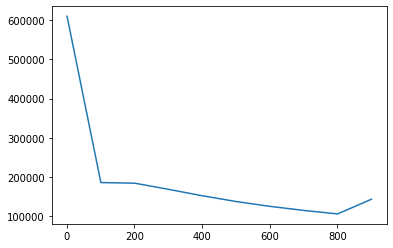

In [129]:
import matplotlib.pyplot as plt

X_axis = range(1, 1001, 100)
Y_axis = result_1000['cost']
plt.plot(X_axis, Y_axis)

##### 4.2 Observe the effect of iteration_num on the test accuracy.

In [132]:
from collections import defaultdict
import time
result_set = defaultdict(list)

learning_rate = 1e-3
for i in range(1000, 10001, 1000): # iterating 1000, 2000, ..., 10000
    n_iterations = i
    print(time.ctime())
    print(n_iterations)
    result = model(X_train, y_train.reshape(-1, 1), X_test, y_test.reshape(-1, 1), n_iterations, learning_rate, print_cost = True)
    result_set[i] = result

result_set = dict(result_set)

Mon Oct 28 20:52:43 2019
1000
Mon Oct 28 20:52:56 2019
2000
Mon Oct 28 20:53:21 2019
3000
Mon Oct 28 20:54:00 2019
4000
Mon Oct 28 20:54:51 2019
5000
Mon Oct 28 20:55:53 2019
6000
Mon Oct 28 20:57:10 2019
7000
Mon Oct 28 20:58:43 2019
8000
Mon Oct 28 21:00:27 2019
9000
Mon Oct 28 21:02:24 2019
10000


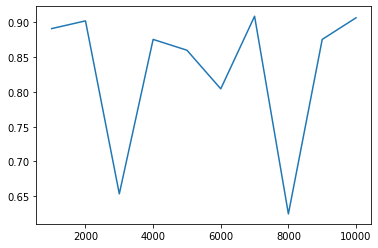

In [138]:
X_axis = list(result_set.keys())
Y_axis = [i['test_accuracy'] for i in result_set.values()]
# print(X_axis)
# print(Y_axis)
## interation_num vs test_accuracy
plt.plot(X_axis, Y_axis)

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digits (0,1,2,3,4,5,6,7,8,9) is in the image.

# Congratulations ! You have completed assigment 4. 